# Условие
Необходимо взять двумерную (или одномерную) функцию и использовать методы сэмплирования, представленные ниже:
1. Rejection sampling
2. Метод Метрополиса-Гастингсона
3. Метод Гибсона

## Полезные ссылки
[Вероятностные модели: сэмплирование](https://habr.com/ru/companies/surfingbird/articles/226677/) -- Habr

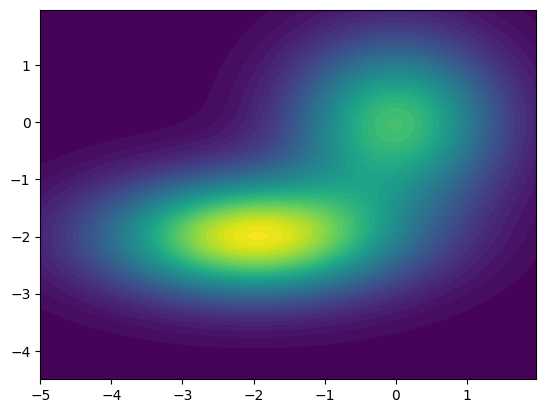

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.mlab as mlab
from scipy.stats import multivariate_normal

x_min, x_max = -5, 2
y_min, y_max = -4.5, 2
count = 1000
def to_sample_func(X, Y, a=0.5, b=0.7):
    #   [mu_x, mu_y], [[sig_x, sig_xy], [sig_xy, sig_y]]
    z1 = multivariate_normal([0,0],[[1.0,0],[0,1.0]])
    z2 = multivariate_normal([-2,-2],[[2,0],[0,0.5]])
    return a*z1.pdf(np.dstack((X,Y))) + b*z2.pdf(np.dstack((X,Y)))

delta = 0.025
x, y = np.meshgrid(np.arange(x_min, x_max, delta), np.arange(y_min, y_max, delta))

plt.contourf(x, y, to_sample_func(x, y), levels = 50)
plt.show()


In [2]:
def rejection_sampler(func_to_sample, ax, bx, ay, by, c, n_samples=1000):
    samples = None
    samples_left = n_samples

    while samples_left > 0:
        x = np.random.uniform(ax, bx, samples_left)
        y = np.random.uniform(ay, by, samples_left)
        z = np.random.uniform(0, c, samples_left)

        probabilities = func_to_sample(x, y)
        new_samples_indexes = np.where(probabilities > z)

        if samples is not None:
            samples = np.concatenate((samples, np.array([x[new_samples_indexes], y[new_samples_indexes]])), axis=1)
        else:
            samples = np.array([x[new_samples_indexes], y[new_samples_indexes]])
            
        samples_left -= len(new_samples_indexes[0])

    return samples

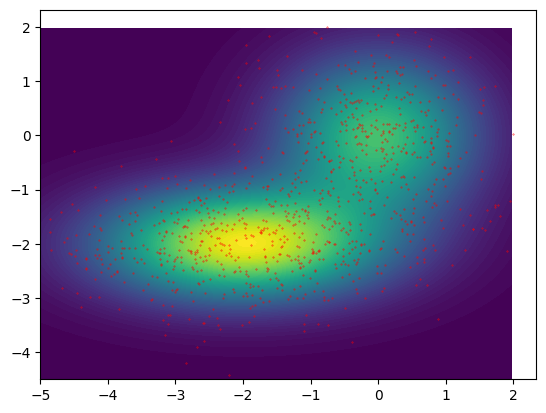

In [3]:
res = rejection_sampler(to_sample_func, x_min, x_max, y_min, y_max, 100, 1000)

plt.contourf(x, y, to_sample_func(x, y), levels = 100)

plt.scatter(res[0], res[1], s = 0.1, c = 'red')

plt.show()

In [4]:
from scipy.stats import multivariate_normal

def metropolis_hastings(func_to_sample, n_steps, sig_x=.05, sig_y=.05):
    steps_left = n_steps
    samples = []
    
    q_sampler = multivariate_normal([0, 0], [[sig_x, 0], [0, sig_y]])

    cur_coord = np.array([0, 0])
    while steps_left > 0:
        next_coord = q_sampler.rvs() + cur_coord
        a = func_to_sample(next_coord[0], next_coord[1]) / func_to_sample(cur_coord[0], cur_coord[1])
        if np.random.binomial(1, min(a,1), 1)[0] == 1:
            cur_coord = next_coord
            samples.append(cur_coord)
        steps_left -= 1
    return np.array(samples)

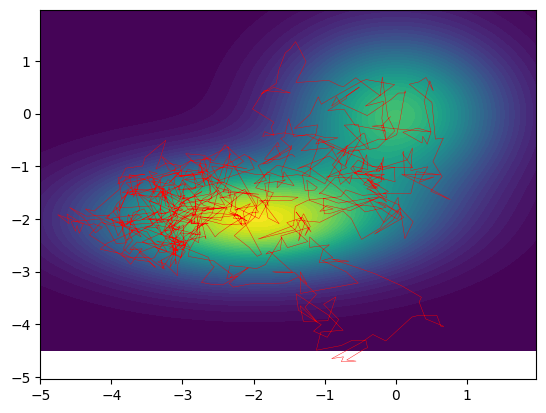

In [5]:
res = metropolis_hastings(to_sample_func, 1000)
plt.plot(res[:, 0], res[:, 1], c = 'red', linewidth = 0.3)

plt.contourf(x, y, to_sample_func(x,y), levels = 50)

plt.show()

In [10]:
from scipy.stats import multivariate_normal

def gibson(func_to_sample, n_steps, x_start, y_start, sig_x=.05, sig_y=.05, axis_count=2):
    steps_left = n_steps
    samples = []
    
    q_sampler = multivariate_normal([0, 0], [[sig_x, 0], [0, sig_y]])

    cur_coord = np.array([x_start, y_start])
    cur_axis = 0 # выбираем по какой оси двигаемся
    while steps_left > 0:
        q_rvs = q_sampler.rvs()
        next_coord = cur_coord.copy()
        next_coord[cur_axis] += q_rvs[cur_axis]
        cur_axis = (cur_axis + 1) % axis_count

        a = func_to_sample(next_coord[0], next_coord[1]) / func_to_sample(cur_coord[0], cur_coord[1])
        if np.random.binomial(1, min(a,1), 1)[0] == 1:
            cur_coord = next_coord
            samples.append(cur_coord)
            steps_left -= 1
    return np.array(samples)

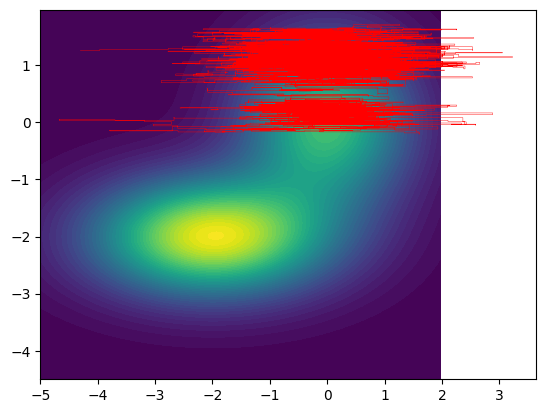

In [15]:
res = gibson(to_sample_func, 5000, -4.3, 1.3, sig_x=1, sig_y=.0007)
plt.plot(res[:, 0], res[:, 1], c = 'red', linewidth = 0.3)

plt.contourf(x, y, to_sample_func(x,y), levels = 50)

plt.show()